In [1]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers = 15)

import matplotlib.pyplot as plt
import numpy as np

INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
import sys
sys.path.append('../utils/')

from utils import *
from TableMapper import *

from tqdm.notebook import tqdm
tqdm.pandas()

In [3]:
query, schema = get_spider_schema_table_files()
tableMapper = TableMapper(query, schema)

In [4]:
res = []
count1 = 0
count2 = 0
excess = 0
def get_counts(schemas):
    count1 = 0
    count2 = 0
    excess = 0
    i = schemas
    s, t = tableMapper.get_filtered_schema(i)
    count_match, count_all, excess_c = tableMapper.get_exact_match_accuracy(s, t, threshold=0.33)
    count1 += count_match
    count2 += count_all
    excess += excess_c
    if(count1 == 0):
        print(i)

    res = [i, count_match/count_all, len(s), len(t)]
    
    return count1, count2, res, excess

In [5]:
%%time
count_df = pd.Series(list(set(schema.schema_id.values))).\
    rename({0 : 'schemas'}).\
    parallel_apply(get_counts)

CPU times: user 289 ms, sys: 253 ms, total: 542 ms
Wall time: 49.5 s


In [6]:
df_results = pd.DataFrame()
df_results[['count1', 'count2', 'res', 'pct_excess']] = pd.DataFrame(pd.DataFrame(count_df)[0].tolist())
df_results

,count1,count2,res,pct_excess
0,38,46,"[aircraft, 0.8260869565217391, 5, 46]",0.695652
1,18,18,"[museum_visit, 1.0, 3, 18]",0.777778
2,9,14,"[soccer_1, 0.6428571428571429, 7, 14]",0.357143
3,17,17,"[roller_coaster, 1.0, 2, 17]",0.000000
4,3,4,"[real_estate_properties, 0.75, 5, 4]",0.000000
...,...,...,...,...
169,18,18,"[journal_committee, 1.0, 3, 18]",0.777778
170,15,18,"[browser_web, 0.8333333333333334, 3, 18]",0.611111
171,18,19,"[flight_company, 0.9473684210526315, 3, 19]",0.684211
172,62,88,"[activity_1, 0.7045454545454546, 5, 88]",0.500000


0.8667400282342044
0.7852184964317137


,schema_id,score,num_tables,num_queries,excess
0,restaurants,0.008000,3,125,0.695652
1,scholar,0.022847,10,569,0.777778
2,academic,0.160221,15,181,0.357143
3,yelp,0.261261,7,111,0.000000
4,imdb,0.266055,16,109,0.000000
...,...,...,...,...,...
169,local_govt_mdm,1.000000,8,14,0.777778
170,course_teach,1.000000,3,30,0.611111
171,orchestra,1.000000,4,40,0.684211
172,musical,1.000000,2,40,0.500000


<AxesSubplot:>

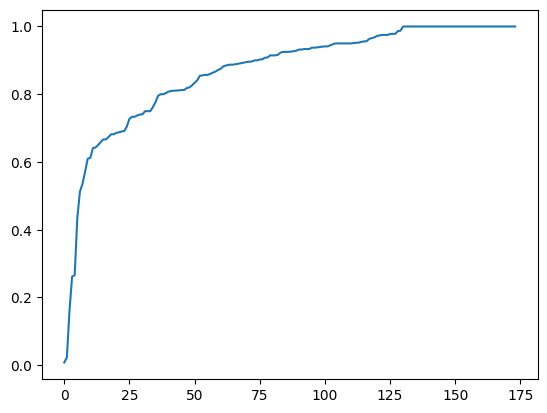

In [7]:
count1 = df_results['count1'].sum()
count2 = df_results['count2'].sum()
score_df = pd.DataFrame(df_results['res'].tolist(), 
                columns = ['schema_id', 'score', 'num_tables', 'num_queries']
            ).sort_values(by = 'score').reset_index(drop = True)
score_df['excess'] = df_results['pct_excess']
print(score_df.score.mean())
print(count1 / count2)
display(score_df)
score_df.score.plot()

,num_tables,excess
num_tables,1.000000,-0.450678
excess,-0.450678,1.000000


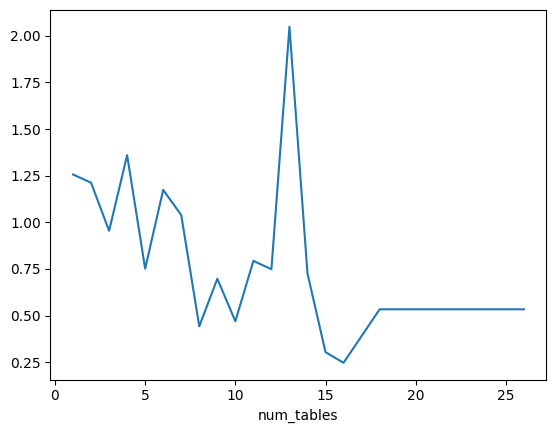

In [8]:
group_df = score_df.groupby('num_tables').mean()['excess']
group_df.plot()
display(group_df.reset_index().corr())

In [9]:
print(count1)
print(count2)

# 5194
# 9685

# 5223
# 9685

8032
10229
